In [24]:
from autogluon.tabular import TabularDataset, TabularPredictor
import os
import numpy as np
import pandas as pd
import tarfile


# Cloud
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role
from autogluon.tabular import TabularPredictor

%run diagnostics.ipynb

In [ ]:
region = sagemaker.Session().boto_region_name
sess = sagemaker.Session()
role = get_execution_role()
bucket = sess.default_bucket()
prefix = 'automl-spaced-repetition'

In [25]:
train_data_s = pd.read_csv(os.path.normpath(os.path.join(os.getcwd(), '../data/processed/train_data.csv')))
test_data_s = pd.read_csv(os.path.normpath(os.path.join(os.getcwd(), '../data/processed/test_data.csv')))

train_data = train_data_s.drop(columns=['session_seen', 'session_correct'])
test_data = test_data_s.drop(columns=['session_seen', 'session_correct'])

In [26]:
# - LEX 
# train_data.drop(columns=['tags_list', 'word_len'], inplace=True)
# test_data.drop(columns=['tags_list', 'word_len'], inplace=True)

# - LEX - U 
train_data.drop(columns=['tags_list', 'word_len', 'avg_delta', 'std_delta', 'avg_h_recall'], inplace=True)
test_data.drop(columns=['tags_list', 'word_len', 'avg_delta', 'std_delta', 'avg_h_recall'], inplace=True)

label = 'p_recall'

train_file = 'train_data_for_sagemaker.csv'
train_data.to_csv(train_file, index=False)

In [ ]:
train_s3_path = f's3://{bucket}/{prefix}/train/{train_file}'
s3 = boto3.client('s3')
s3.upload_file(train_file, bucket, f'{prefix}/train/{train_file}')

In [ ]:
auto_ml_estimator = Estimator(
    image_uri=sagemaker.image_uris.retrieve('autogluon', sess.boto_region_name, version='0.8'),
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output',
    base_job_name='autogluon-job',
    sagemaker_session=sess,
    hyperparameters={
        'target': label,
        'presets': 'best_quality',
        'problem_type': 'regression',
        # 'excluded_model_types': 'NeuralNetTorch,NeuralNetFastAI,KNeighborsDist,KNeighborsUnif,LightGBM,LightGBMXT,RandomForestMSE',
        # 'included_model_types': 'XGBoost',
        'auto_stack': 'False',
        'save_space': 'True'
    }
)

auto_ml_estimator.fit({'train': TrainingInput(train_s3_path, content_type='csv')})

In [ ]:
model_path = 'AutoML_Spaced_Repetition'

In [ ]:
model_artifact = auto_ml_estimator.model_data
s3.download_file(bucket, model_artifact.replace(f's3://{bucket}/', ''), 'model.tar.gz')


In [ ]:
import tarfile
with tarfile.open('model.tar.gz') as tar:
    tar.extractall(path=model_path)

In [ ]:
predictor = TabularPredictor.load(model_path)

In [32]:
print('best model:', predictor.model_best)

best model: WeightedEnsemble_L2


In [33]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost,-0.264324,root_mean_squared_error,1.180075,227.658684,1.180075,227.658684,1,True,1
1,WeightedEnsemble_L2,-0.264324,root_mean_squared_error,1.181109,227.661183,0.001034,0.002499,2,True,2


In [34]:
models = predictor.model_names()

In [35]:
from sklearn.metrics import mean_absolute_error

In [36]:
for i in range(len(models)):
    y_pred = predictor.predict(test_data.drop(columns=[label]), model=models[i])
    y_pred = cap_y(y_pred)
    y_test = test_data['p_recall']
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"Model: {models[i]}, MAE: {mae:.4f}")
    

Model: XGBoost, MAE: 0.1665
Model: WeightedEnsemble_L2, MAE: 0.1665


In [37]:
results_df = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred, 'session_seen':test_data_s['session_seen'], 
                          'session_correct':test_data_s['session_correct']})
results_df.head()

,y_test,y_pred,session_seen,session_correct
0,1.000000,0.911987,1,1
1,0.857143,0.853847,7,6
2,0.875000,0.869030,8,7
3,1.000000,0.893905,1,1
4,1.000000,0.918437,2,2


In [38]:
print('mae:', (results_df['y_test'] - results_df['y_pred']).abs().mean())

mae: 0.16648104458048768


In [39]:
predictor.evaluate(test_data, silent=True)

{'root_mean_squared_error': -0.2654613725829721,
 'mean_squared_error': -0.07046974033363552,
 'mean_absolute_error': -0.1664857215812197,
 'r2': 0.03468691589208839,
 'pearsonr': 0.1862517955018118,
 'median_absolute_error': -0.10053771734237671}

In [40]:
predictor.info()

{'path': '/Users/julkakubisa/Documents/PRACA MAGISTERSKA/spaced_repetition_algorithms/notebooks/AutogluonModels/ag-20250711_144511',
 'label': 'p_recall',
 'random_state': 0,
 'version': '1.2',
 'features': ['Unnamed: 0',
  'SUBTLEX',
  'delta',
  'history_seen',
  'history_correct',
  'h_recall',
  'lang_combination'],
 'feature_metadata_in': <autogluon.common.features.feature_metadata.FeatureMetadata at 0x32a562ed0>,
 'time_fit_preprocessing': 8.0028076171875,
 'time_fit_training': 229.56761598587036,
 'time_fit_total': 237.57042360305786,
 'time_limit': None,
 'time_train_start': 1752245120.008895,
 'num_rows_train': 9904079,
 'num_cols_train': 7,
 'num_rows_val': 100042,
 'num_rows_test': None,
 'num_classes': None,
 'problem_type': 'regression',
 'eval_metric': 'root_mean_squared_error',
 'best_model': 'WeightedEnsemble_L2',
 'best_model_score_val': -0.26432437553209986,
 'best_model_stack_level': 2,
 'num_models_trained': 2,
 'num_bag_folds': 0,
 'max_stack_level': 2,
 'max_core_

Text(0.5, 1.0, 'Predicted vs. Actual Recall Probability')

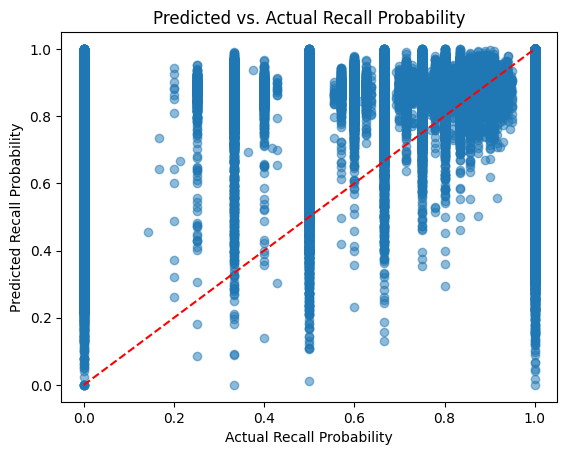

In [41]:
import matplotlib.pyplot as plt

predictions_scatterplot = plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Actual Recall Probability")
plt.ylabel("Predicted Recall Probability")
plt.title("Predicted vs. Actual Recall Probability")

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
results_df.describe()

In [ ]:
results = predictor.fit_summary()
results["leaderboard"]

In [ ]:
predictor.leaderboard(test_data)

In [ ]:
predictor.feature_importance(test_data)

In [42]:
expanded_df = results_df.loc[results_df.index.repeat(results_df["session_seen"])].reset_index(drop=True)
expanded_df["outcome"] = np.concatenate([
    np.concatenate([np.ones(int(c)), np.zeros(int(s - c))])  # c correct, (s-c) incorrect
    for s, c in zip(results_df["session_seen"], results_df["session_correct"])
])

In [ ]:
expanded_df.head()

In [ ]:
xgboost = expanded_df.drop(columns=['session_seen', 'session_correct'])

current_dir = os.getcwd()


filepath = os.path.normpath(os.path.join(current_dir, '../results/'))
xgboost.to_csv(os.path.join(filepath, 'xgboost.csv'), sep='\t', index=False, header=True)

In [ ]:
plot_calibration(expanded_df['outcome'], expanded_df['y_pred'], 'BetterXGB_calibration_plot.png')

In [43]:
%run diagnostics.ipynb
import matplotlib.pyplot as plt

AUC Score: 0.6243


NameError: name 'current_dir' is not defined

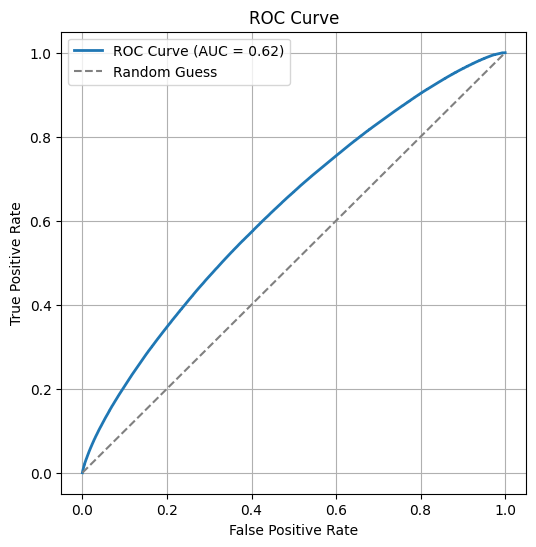

In [44]:
AUC_ROC(expanded_df['outcome'], expanded_df['y_pred'], 'BetterXGB_ROC_plot.png')

In [ ]:
plot_lift(expanded_df, expanded_df['y_pred'], 'BetterXGB_Lift_plot.png')